## 라이브러리

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import missingno as msno

import sklearn
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

print('xgboost version:', xgb.__version__)
print('lightgbm version:',lgb.__version__)
print('missingno version:',msno.__version__)
print('sklearn version:',sklearn.__version__)


xgboost version: 1.7.6
lightgbm version: 3.3.5
missingno version: 0.5.2
sklearn version: 1.2.2


## 데이터 전처리
X : train 데이터
- id, price 컬럼 삭제
- date : 년월일 6자리 수정
y : 'price'

In [4]:
train = pd.read_csv('./data/train.csv')

X = train.copy()
y = train['price']

X.drop(['id', 'price'], axis=1, inplace=True)
X['date'] = X['date'].apply(lambda i: i[:6]).astype(int)

X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int32  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 각 변수 분포 확인

19 2 10


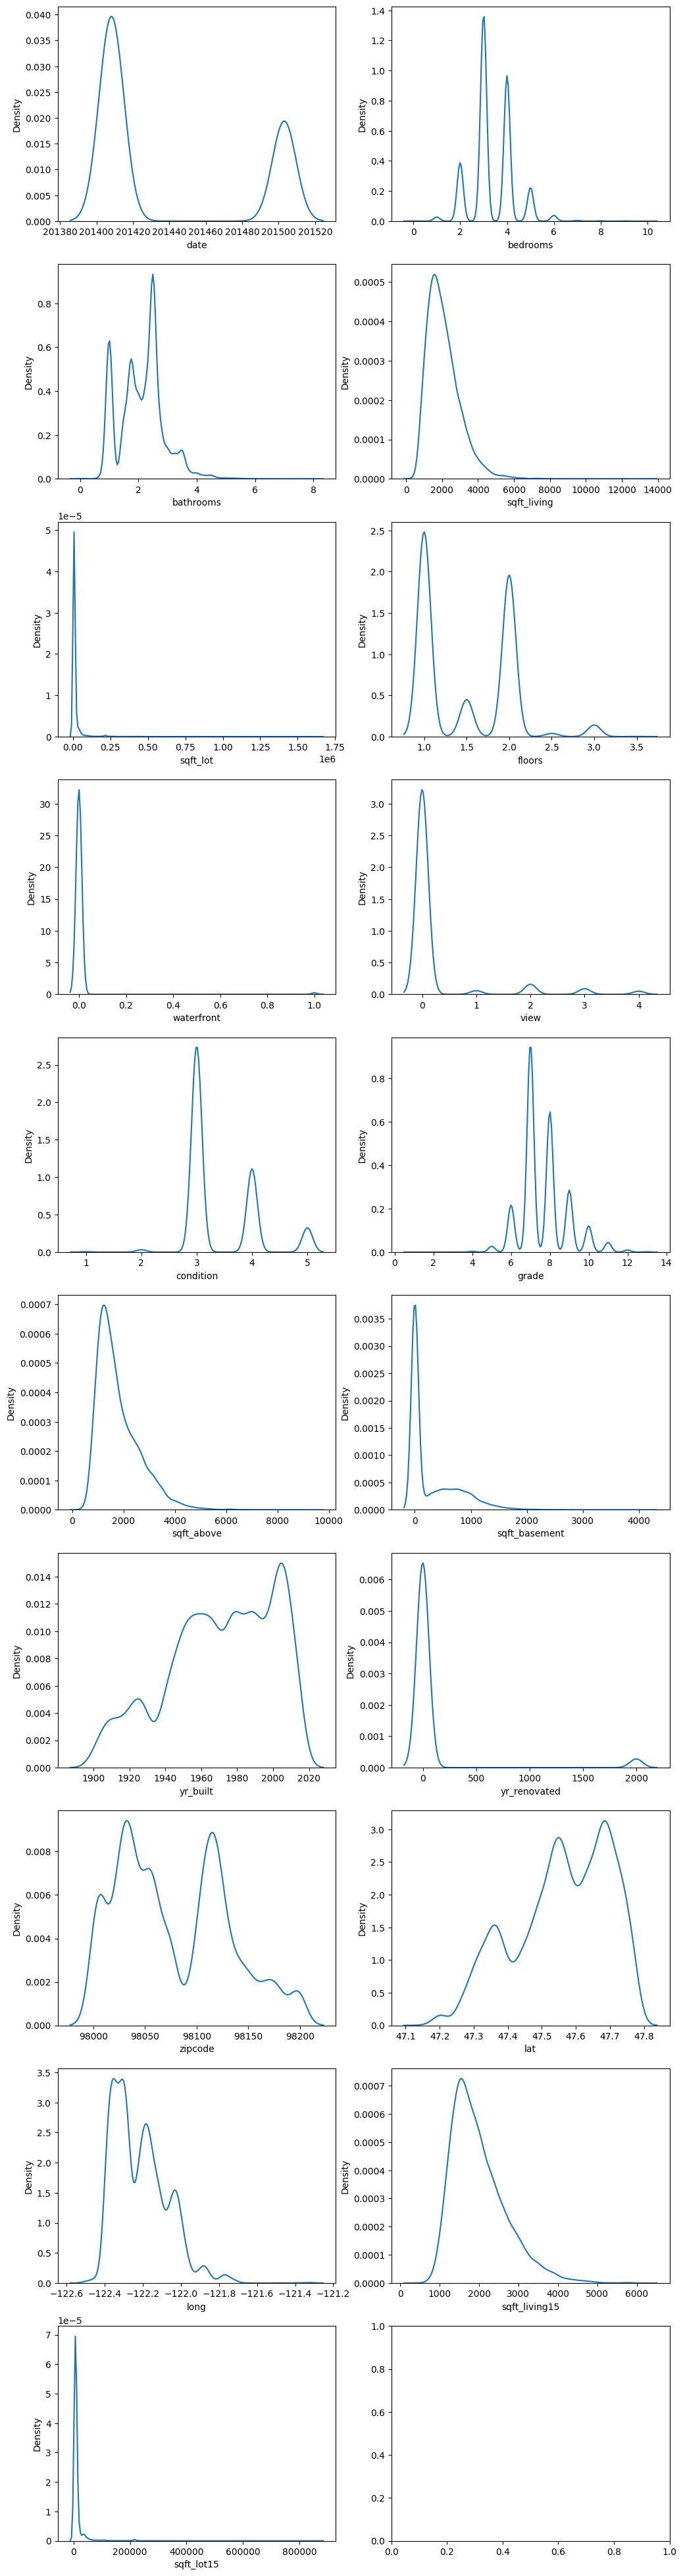

In [5]:
def show_kdeplot(X, plot_col=2, figsize=(12,50)):
    columns = X.columns
    columns_len = len(columns)
    plot_col = plot_col
    plot_row = columns_len // plot_col
    if columns_len % plot_col:
        plot_row += 1
    print(columns_len, plot_col, plot_row)
    fig, ax = plt.subplots(plot_row, plot_col, figsize=figsize)
    for i in range(columns_len):
        plot_ax = ax[i // plot_col][i % plot_col]
        column = columns[i]
        data = X[column]
        sns.kdeplot(data=data, ax=plot_ax)

show_kdeplot(X)

    

### 한쪽으로 치우친 데이터 정규분포화 처리

19 2 10


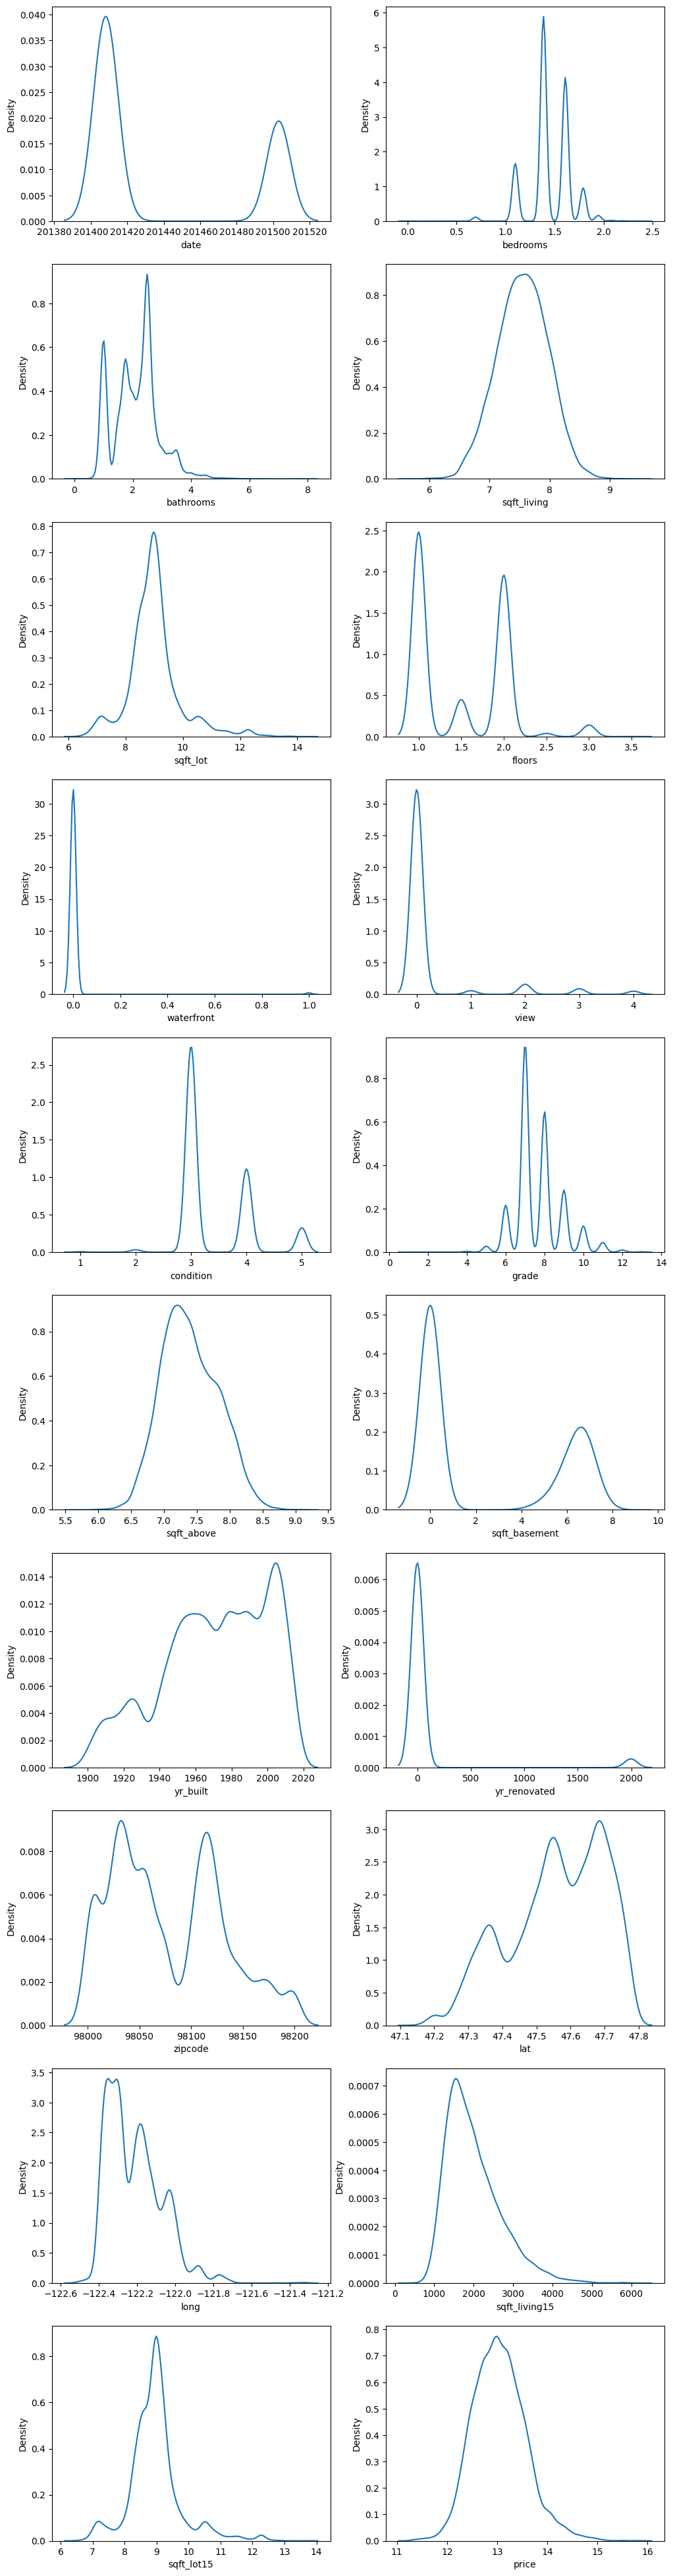

In [6]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']
for c in skew_columns:
    X[c] = np.log1p(X[c].values)

show_kdeplot(X)

y = np.log1p(y)
sns.kdeplot(y)
plt.show()

## 모델링

In [7]:
random_state = 2023
# gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [gboost, xgboost, lightgbm, rdforest]
models = [xgboost, lightgbm]


## GridSearch

In [8]:
def my_GridSearch(models, X, y, param_grid, verbose=2, n_jobs=5):
    results = pd.DataFrame()
    for model in models:
        grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                                cv=5, verbose=verbose, n_jobs=n_jobs)
        grid_model.fit(X, y)
        params = grid_model.cv_results_['params']
        score = grid_model.cv_results_['mean_test_score']
        
        tmp = pd.DataFrame(params)
        tmp['score'] = score
        tmp['RMSLE'] = np.sqrt(-1 * score)
        tmp['model'] = model.__class__.__name__
        results = pd.concat([results, tmp])
    return results.sort_values('RMSLE')

param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [5, 10],
    'learning_rate': [0.1]
}

results = my_GridSearch(models, X, y, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [9]:
results.head()

,learning_rate,max_depth,n_estimators,score,RMSLE,model
0,0.1,5,500,-0.026139,0.161674,XGBRegressor
2,0.1,10,500,-0.026241,0.161990,LGBMRegressor
1,0.1,5,1000,-0.026289,0.162138,XGBRegressor
0,0.1,5,500,-0.026454,0.162645,LGBMRegressor
3,0.1,10,1000,-0.026737,0.163514,LGBMRegressor


## 앙상블 모델 및 하이퍼 파라미터 선택
1. XGBRegressor - max_depth:5, n_estimators:500
1. LGBMRegressor - max_depth:10, n_estimators:500

In [14]:
model1 = XGBRegressor(max_depth = 5, n_estimators = 500, random_state=random_state)
model2 = LGBMRegressor(learning_rate = 0.1, max_depth = 10, n_estimators = 500, random_state=random_state)
sub_models = [model1, model2]

## submission 데이터 전처리

19 2 10


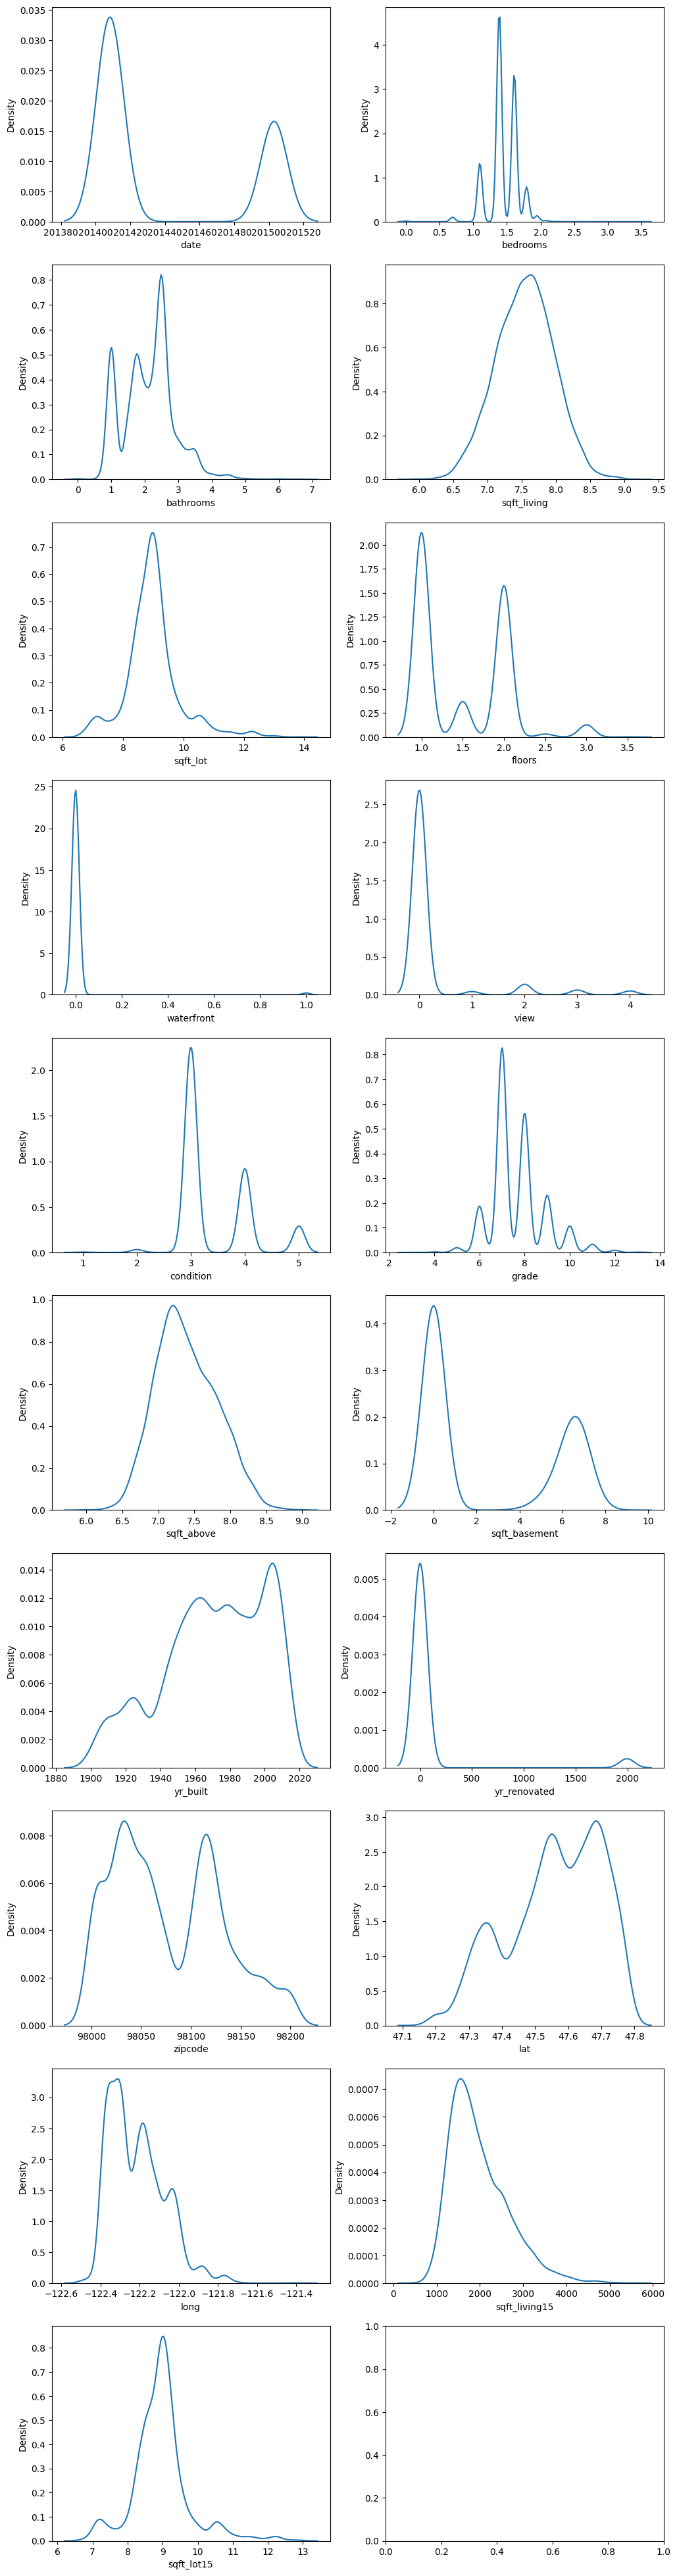

In [13]:
test = pd.read_csv('./data/test.csv')
sub = test.copy()
sub.drop(['id'], axis=1, inplace=True)
sub['date'] = sub['date'].apply(lambda i: i[:6]).astype(int)    
for c in skew_columns:
    sub[c] = np.log1p(sub[c].values)
sub.head()
show_kdeplot(sub)

In [17]:
def ensemble_fit_predict(models, train_X, train_y, test):
    prediction = None
    for model in models:
        model.fit(train_X, train_y)
        pred = model.predict(test)
        if prediction is None:
            prediction = np.expm1(pred)
        else:
            prediction += np.expm1(pred)
    return prediction / len(models)

prediction = ensemble_fit_predict(sub_models, X, y, sub)
prediction

array([ 542003.7 ,  485102.4 , 1364823.9 , ...,  486136.  ,  330533.44,
        465917.06], dtype=float32)

## Submission 파일 저장

In [20]:
sample = pd.read_csv('./data/sample_submission.csv')
submission = sample.copy()
submission['price'] = prediction
submission.to_csv('./data/submission.csv', index=False)
submission.head()


,id,price
0,15035,5.420037e+05
1,15036,4.851024e+05
2,15037,1.364824e+06
3,15038,2.955618e+05
4,15039,3.286023e+05
